Рабочий код модели:

./llama-server -m ../../../.cache/huggingface/hub/models--unsloth--Qwen3-30B-A3B-GGUF/snapshots/7db7f59503edb0c41e94e7c38f9d7e6717ded423/Qwen3-30B-A3B-Q4_K_M.gguf --alias "qwen3-30-lmstudio" -c 30000 -ngl 99 -np 8 --host 0.0.0.0 --port 30000 --jinja --metrics --no-context-shift --reasoning-format deepseek

In [1]:
import re
import os
from typing import Optional, Union
from deepeval.models import DeepEvalBaseLLM
from openai import OpenAI, AsyncOpenAI
from pydantic import BaseModel
import instructor

class SGlangModel(DeepEvalBaseLLM):
    def __init__(self, 
                 model_name: str, 
                 base_url: str, 
                 api_key: Optional[str] = "NET",
                 enable_thinking: bool = False): # Параметр для управления режимом мышления Qwen3
        """
        Инициализирует модель SGlang.

        Args:
            model_name (str): Имя модели.
            base_url (str): Базовый URL для API.
            api_key (Optional[str]): API ключ. По умолчанию "NET".
            enable_thinking (bool): Флаг для управления поведением моделей Qwen3.
                                     Если True, к промпту для Qwen3 будет добавлен "/think" (для стимуляции процесса размышления).
                                     Если False, к промпту для Qwen3 будет добавлен "/no_think".
                                     Вне зависимости от этого флага, блок <think> будет удален из финального вывода
                                     для Qwen3 в режиме генерации текста (когда schema is None).
                                     По умолчанию False.
        """
        self.model_name = model_name
        self.base_url = base_url
        self.api_key = api_key if api_key is not None else os.getenv("OPENAI_API_KEY")
        self.enable_thinking = enable_thinking 
        self._sync_client: Optional[OpenAI] = None
        self._async_client: Optional[AsyncOpenAI] = None

    def load_model(self) -> OpenAI:
        if self._sync_client is None:
            self._sync_client = OpenAI(base_url=self.base_url, api_key=self.api_key)
        return self._sync_client

    def load_async_model(self) -> AsyncOpenAI:
        if self._async_client is None:
            self._async_client = AsyncOpenAI(base_url=self.base_url, api_key=self.api_key)
        return self._async_client

    def _clean_qwen3_output(self, text_response: str) -> str:
        """
        Удаляет начальный блок <think>...</think> из ответов модели Qwen3.
        """
        pattern = r'^\s*<think>.*?</think>\s*'
        cleaned_response = re.sub(pattern, '', text_response, count=1, flags=re.DOTALL)
        return cleaned_response

    def generate(self, prompt: str, schema: Optional[BaseModel] = None) -> Union[str, BaseModel]:
        """
        Генерирует ответ от модели. 
        Для модели 'Qwen3' (без схемы):
        - К промпту добавляется "/think" или "/no_think" в зависимости от self.enable_thinking.
        - Блок <think> всегда удаляется из финального ответа.
        """
        client = self.load_model()
        
        processed_prompt = prompt
        # Проверка на Qwen3 (нечувствительная к регистру) и отсутствие схемы
        is_qwen3_text_mode = "qwen3" in self.model_name.lower() and schema is None

        if is_qwen3_text_mode:
            # Удаляем существующие теги /think или /no_think из конца промпта
            processed_prompt = re.sub(r'\s*/think\s*$', '', processed_prompt, flags=re.IGNORECASE).strip()
            processed_prompt = re.sub(r'\s*/no_think\s*$', '', processed_prompt, flags=re.IGNORECASE).strip()
            
            if self.enable_thinking:
                processed_prompt += " /think" # Инструктируем Qwen3 выполнить процесс размышления
            else:
                processed_prompt += " /no_think" # Инструктируем Qwen3 пропустить/минимизировать размышления
        
        try:
            if schema is None:
                response = client.chat.completions.create(
                    model=self.model_name,
                    messages=[{"role": "user", "content": processed_prompt}], 
                )
                raw_content = response.choices[0].message.content
                
                if is_qwen3_text_mode:
                    # Для Qwen3 в текстовом режиме всегда очищаем вывод от блока <think>.
                    # self.enable_thinking контролирует, получает ли модель /think или /no_think в промпте,
                    # т.е. будет ли она проходить через процесс размышления.
                    return self._clean_qwen3_output(raw_content)
                else:
                    # Для других моделей возвращаем "сырой" контент
                    return raw_content
            else:
                # Режим структурированного вывода с instructor
                instructor_client = instructor.from_openai(
                    client=client,
                    mode=instructor.Mode.JSON 
                )
                response_obj = instructor_client.chat.completions.create(
                    model=self.model_name,
                    messages=[{"role": "user", "content": prompt}], 
                    response_model=schema, 
                )
                return response_obj
        except Exception as e:
            print(f"Ошибка при синхронной генерации VLLM/Instructor для промпта '{prompt[:50]}...': {e}")
            raise e

    async def a_generate(self, prompt: str, schema: Optional[BaseModel] = None) -> Union[str, BaseModel]:
        """
        Асинхронно генерирует ответ от модели.
        Для модели 'Qwen3' (без схемы):
        - К промпту добавляется "/think" или "/no_think" в зависимости от self.enable_thinking.
        - Блок <think> всегда удаляется из финального ответа.
        """
        client = self.load_async_model()

        processed_prompt = prompt
        # Проверка на Qwen3 (нечувствительная к регистру) и отсутствие схемы
        is_qwen3_text_mode = "qwen3" in self.model_name.lower() and schema is None

        if is_qwen3_text_mode:
            # Удаляем существующие теги /think или /no_think из конца промпта
            processed_prompt = re.sub(r'\s*/think\s*$', '', processed_prompt, flags=re.IGNORECASE).strip()
            processed_prompt = re.sub(r'\s*/no_think\s*$', '', processed_prompt, flags=re.IGNORECASE).strip()

            if self.enable_thinking:
                processed_prompt += " /think" # Инструктируем Qwen3 выполнить процесс размышления
            else:
                processed_prompt += " /no_think" # Инструктируем Qwen3 пропустить/минимизировать размышления

        try:
            if schema is None:
                response = await client.chat.completions.create(
                    model=self.model_name,
                    messages=[{"role": "user", "content": processed_prompt}], 
                )
                raw_content = response.choices[0].message.content

                if is_qwen3_text_mode:
                    # Для Qwen3 в текстовом режиме всегда очищаем вывод от блока <think>.
                    # self.enable_thinking контролирует, получает ли модель /think или /no_think в промпте.
                    return self._clean_qwen3_output(raw_content)
                else:
                    # Для других моделей возвращаем "сырой" контент
                    return raw_content
            else:
                # Режим структурированного вывода с instructor
                instructor_client = instructor.from_openai(
                    client=client,
                    mode=instructor.Mode.JSON
                )
                response_obj = await instructor_client.chat.completions.create(
                    model=self.model_name,
                    messages=[{"role": "user", "content": prompt}], 
                    response_model=schema,
                )
                return response_obj
        except Exception as e:
            print(f"Ошибка при асинхронной генерации VLLM/Instructor для промпта '{prompt[:50]}...': {e}")
            raise e

    def get_model_name(self) -> str:
        return self.model_name

In [2]:
from deepeval.models import DeepEvalBaseEmbeddingModel
from typing import List

class InfinityEmbeddingModel(DeepEvalBaseEmbeddingModel):
    def __init__(self, model_name: str, base_url: str, api_key: Optional[str] = "NET"):
        self.model_name = model_name
        self.base_url = base_url
        self.api_key = api_key if api_key is not None else os.getenv("OPENAI_API_KEY", "123")
        self._sync_client: Optional[OpenAI] = None
        self._async_client: Optional[AsyncOpenAI] = None

    def load_model(self) -> OpenAI:
        if self._sync_client is None:
            self._sync_client = OpenAI(base_url=self.base_url, api_key=self.api_key)
        return self._sync_client

    def load_async_model(self) -> AsyncOpenAI:
        if self._async_client is None:
            self._async_client = AsyncOpenAI(base_url=self.base_url, api_key=self.api_key)
        return self._async_client

    def embed_text(self, text: str) -> List[float]:
        client = self.load_model()
        try:
            response = client.embeddings.create(
                model=self.model_name,
                input=text
            )
            return response.data[0].embedding
        except Exception as e:
            print(f"Error during synchronous Infinity embedding for text '{text[:50]}...': {e}")
            return []

    def embed_texts(self, texts: List[str]) -> List[List[float]]:
        client = self.load_model()
        try:
            response = client.embeddings.create(
                model=self.model_name,
                input=texts
            )
            return [data.embedding for data in response.data]
        except Exception as e:
            print(f"Error during synchronous Infinity batch embedding: {e}")
            return [[] for _ in texts] 

    async def a_embed_text(self, text: str) -> List[float]:
        client = self.load_async_model()
        try:
            response = await client.embeddings.create(
                model=self.model_name,
                input=text
            )
            return response.data[0].embedding
        except Exception as e:
            print(f"Error during asynchronous Infinity embedding for text '{text[:50]}...': {e}")
            return []

    async def a_embed_texts(self, texts: List[str]) -> List[List[float]]:
        client = self.load_async_model()
        try:
            response = await client.embeddings.create(
                model=self.model_name,
                input=texts
            )
            return [data.embedding for data in response.data]
        except Exception as e:
            print(f"Error during asynchronous Infinity batch embedding: {e}")
            return [[] for _ in texts]


    def get_model_name(self) -> str:
        """
        Returns the name of the embedding model.
        """
        return self.model_name

In [3]:
BertaEmbeddings = InfinityEmbeddingModel(model_name="sergeyzh/BERTA", base_url="http://127.0.0.1:7997", api_key = "123")


In [4]:
# import re  
# import os  
# import json  
# from typing import Optional, Union  
# from deepeval.models import DeepEvalBaseLLM  
# from openai import OpenAI, AsyncOpenAI  
# from pydantic import BaseModel  
  
# class SGlangModel(DeepEvalBaseLLM):  
#     def __init__(self,   
#                  model_name: str,   
#                  base_url: str,   
#                  api_key: Optional[str] = "NET",  
#                  enable_thinking: bool = False):  
#         """  
#         Инициализирует модель SGlang.  
  
#         Args:  
#             model_name (str): Имя модели.  
#             base_url (str): Базовый URL для API.  
#             api_key (Optional[str]): API ключ. По умолчанию "NET".  
#             enable_thinking (bool): Флаг для управления поведением моделей Qwen3.  
#                                      Если True, к промпту для Qwen3 будет добавлен "/think".  
#                                      Если False, к промпту для Qwen3 будет добавлен "/no_think".  
#                                      По умолчанию False.  
#         """  
#         self.model_name = model_name  
#         self.base_url = base_url  
#         self.api_key = api_key if api_key is not None else os.getenv("OPENAI_API_KEY")  
#         self.enable_thinking = enable_thinking   
#         self._sync_client: Optional[OpenAI] = None  
#         self._async_client: Optional[AsyncOpenAI] = None  
  
#     def load_model(self) -> OpenAI:  
#         if self._sync_client is None:  
#             self._sync_client = OpenAI(base_url=self.base_url, api_key=self.api_key)  
#         return self._sync_client  
  
#     def load_async_model(self) -> AsyncOpenAI:  
#         if self._async_client is None:  
#             self._async_client = AsyncOpenAI(base_url=self.base_url, api_key=self.api_key)  
#         return self._async_client  
  
#     def _clean_qwen3_output(self, text_response: str) -> str:  
#         """  
#         Удаляет начальный блок <think>...</think> из ответов модели Qwen3.  
#         """  
#         pattern = r'^\s*<think>.*?</think>\s*'  
#         cleaned_response = re.sub(pattern, '', text_response, count=1, flags=re.DOTALL)  
#         return cleaned_response  
  
#     def _trim_and_load_json(self, input_string: str) -> dict:  
#         """  
#         Обрабатывает строку JSON, удаляя лишние символы и преобразуя в словарь.  
#         """  
#         start = input_string.find("{")  
#         end = input_string.rfind("}") + 1  
#         if end == 0 and start != -1:  
#             input_string = input_string + "}"  
#             end = len(input_string)  
#         jsonStr = input_string[start:end] if start != -1 and end != 0 else ""  
#         jsonStr = re.sub(r",\s*([\]}])", r"\1", jsonStr)  
#         try:  
#             return json.loads(jsonStr)  
#         except json.JSONDecodeError:  
#             error_str = "Модель вывела некорректный JSON. Пожалуйста, используйте более надежную модель."  
#             raise ValueError(error_str)  
#         except Exception as e:  
#             raise Exception(f"Произошла непредвиденная ошибка: {str(e)}")  
  
#     def generate(self, prompt: str, schema: Optional[BaseModel] = None) -> Union[str, BaseModel]:  
#         """  
#         Генерирует ответ от модели.   
#         Для модели 'Qwen3' (без схемы):  
#         - К промпту добавляется "/think" или "/no_think" в зависимости от self.enable_thinking.  
#         - Блок <think> всегда удаляется из финального ответа.  
          
#         Returns:  
#             Union[str, BaseModel]: Результат генерации  
#         """  
#         client = self.load_model()  
          
#         processed_prompt = prompt  
#         # Проверка на Qwen3 (нечувствительная к регистру) и отсутствие схемы  
#         is_qwen3_text_mode = "qwen3" in self.model_name.lower() and schema is None  
  
#         if is_qwen3_text_mode:  
#             # Удаляем существующие теги /think или /no_think из конца промпта  
#             processed_prompt = re.sub(r'\s*/think\s*$', '', processed_prompt, flags=re.IGNORECASE).strip()  
#             processed_prompt = re.sub(r'\s*/no_think\s*$', '', processed_prompt, flags=re.IGNORECASE).strip()  
              
#             if self.enable_thinking:  
#                 processed_prompt += " /think" # Инструктируем Qwen3 выполнить процесс размышления  
#             else:  
#                 processed_prompt += " /no_think" # Инструктируем Qwen3 пропустить/минимизировать размышления  
          
#         try:  
#             if schema is None:  
#                 response = client.chat.completions.create(  
#                     model=self.model_name,  
#                     messages=[{"role": "user", "content": processed_prompt}],   
#                 )  
#                 raw_content = response.choices[0].message.content  
                  
#                 if is_qwen3_text_mode:  
#                     # Для Qwen3 в текстовом режиме всегда очищаем вывод от блока <think>  
#                     return self._clean_qwen3_output(raw_content)  
#                 else:  
#                     # Для других моделей возвращаем "сырой" контент  
#                     return raw_content  
#             else:  
#                 # Всегда используем lm-format-enforcer через vLLM API  
#                 response = client.chat.completions.create(  
#                     model=self.model_name,  
#                     messages=[{"role": "user", "content": processed_prompt}],  
#                     extra_body={  
#                         "guided_json": schema.model_json_schema(),  
#                         "guided_decoding_backend": "lm-format-enforcer"  
#                     }  
#                 )  
#                 raw_content = response.choices[0].message.content  
                  
#                 # Преобразуем JSON-строку в объект схемы  
#                 json_data = self._trim_and_load_json(raw_content)  
#                 return schema.model_validate(json_data)  
#         except Exception as e:  
#             print(f"Ошибка при синхронной генерации для промпта '{prompt[:50]}...': {e}")  
#             raise e  
  
#     async def a_generate(self, prompt: str, schema: Optional[BaseModel] = None) -> Union[str, BaseModel]:  
#         """  
#         Асинхронно генерирует ответ от модели.  
#         Для модели 'Qwen3' (без схемы):  
#         - К промпту добавляется "/think" или "/no_think" в зависимости от self.enable_thinking.  
#         - Блок <think> всегда удаляется из финального ответа.  
          
#         Returns:  
#             Union[str, BaseModel]: Результат генерации  
#         """  
#         client = self.load_async_model()  
  
#         processed_prompt = prompt  
#         # Проверка на Qwen3 (нечувствительная к регистру) и отсутствие схемы  
#         is_qwen3_text_mode = "qwen3" in self.model_name.lower() and schema is None  
  
#         if is_qwen3_text_mode:  
#             # Удаляем существующие теги /think или /no_think из конца промпта  
#             processed_prompt = re.sub(r'\s*/think\s*$', '', processed_prompt, flags=re.IGNORECASE).strip()  
#             processed_prompt = re.sub(r'\s*/no_think\s*$', '', processed_prompt, flags=re.IGNORECASE).strip()  
  
#             if self.enable_thinking:  
#                 processed_prompt += " /think" # Инструктируем Qwen3 выполнить процесс размышления  
#             else:  
#                 processed_prompt += " /no_think" # Инструктируем Qwen3 пропустить/минимизировать размышления  
  
#         try:  
#             if schema is None:  
#                 response = await client.chat.completions.create(  
#                     model=self.model_name,  
#                     messages=[{"role": "user", "content": processed_prompt}],   
#                 )  
#                 raw_content = response.choices[0].message.content  
  
#                 if is_qwen3_text_mode:  
#                     # Для Qwen3 в текстовом режиме всегда очищаем вывод от блока <think>  
#                     return self._clean_qwen3_output(raw_content)  
#                 else:  
#                     # Для других моделей возвращаем "сырой" контент  
#                     return raw_content  
#             else:  
#                 # Всегда используем lm-format-enforcer через vLLM API  
#                 response = await client.chat.completions.create(  
#                     model=self.model_name,  
#                     messages=[{"role": "user", "content": processed_prompt}],  
#                     extra_body={  
#                         "guided_json": schema.model_json_schema(),  
#                         "guided_decoding_backend": "lm-format-enforcer"  
#                     }  
#                 )  
#                 raw_content = response.choices[0].message.content  
                  
#                 # Преобразуем JSON-строку в объект схемы  
#                 json_data = self._trim_and_load_json(raw_content)  
#                 return schema.model_validate(json_data)  
#         except Exception as e:  
#             print(f"Ошибка при асинхронной генерации для промпта '{prompt[:50]}...': {e}")  
#             raise e  
  
#     def get_model_name(self) -> str:  
#         return self.model_name

## deepcogito/cogito-v1-preview-llama-8B

In [4]:
Qwen3_8B_Reasoning = SGlangModel(model_name="Qwen/Qwen3-8B", base_url="http://85.143.167.11:30000/v1", enable_thinking= True)
Qwen3_8B= SGlangModel(model_name="Qwen/Qwen3-8B", base_url="http://85.143.167.11:30000/v1", enable_thinking= False)

In [5]:
Qwen3_8B.generate("1")

'Hello! How can I assist you today? 😊'

In [9]:
from deepeval.synthesizer import Synthesizer, Evolution  
from deepeval.synthesizer.config import StylingConfig, EvolutionConfig, ContextConstructionConfig, FiltrationConfig  
  
context_construction_config = ContextConstructionConfig(  
    chunk_size=2000,                 
    chunk_overlap=200,            
    max_contexts_per_document=5,
    context_quality_threshold=0.7,
    max_retries=2,
    critic_model = Qwen3_8B,
    embedder = BertaEmbeddings)  
  
styling_config = StylingConfig(  
    input_format="""Сложные академические вопросы на русском языке, основанные на содержании медицинских учебников.   
    Вопросы должны быть сформулированы с использованием точной медицинской терминологии,   
    требовать глубокого понимания материала и проверять способность применять теоретические знания   
    к клиническим ситуациям.""",  
      
    expected_output_format="""Структурированные, научно обоснованные ответы на русском языке,   
    включающие ключевые концепции из учебника, точные определения, классификации и механизмы.   
    Ответы должны быть организованы в логической последовательности с использованием подзаголовков, где это уместно.""",  
      
    task="""Создание высококачественных экзаменационных вопросов на русском языке,   
    которые точно отражают содержание учебника и проверяют глубину понимания материала.""",  
      
    scenario="""Преподаватель медицинского вуза создает банк вопросов для экзаменов,   
    тестирования и самопроверки студентов. Вопросы должны точно соответствовать   
    содержанию учебников и быть пригодными для оценки компетенций студентов   
    разных курсов медицинского образования.""",  
)  
  
evolution_config = EvolutionConfig(  
    num_evolutions=2, 
    evolutions={  
        Evolution.CONCRETIZING: 0.25,     
        Evolution.MULTICONTEXT: 0.25,   
        Evolution.COMPARATIVE: 0.25,   
        Evolution.CONSTRAINED: 0.25,
    }  
) 

filtration_config = FiltrationConfig(  
    synthetic_input_quality_threshold=0.6,
    critic_model= Qwen3_8B_Reasoning,
    max_quality_retries=2                
)

synthesizer = Synthesizer(
    model=Qwen3_8B_Reasoning,  
    styling_config=styling_config,  
    evolution_config=evolution_config,
    filtration_config=filtration_config,  
    async_mode=True,  
    max_concurrent=20
)  
  


In [6]:
goldens = await synthesizer.a_generate_goldens_from_docs(  
    document_paths=['/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other/docs/for_golds/Anatomia_cheloveka_1_tom_2.pdf',
                    '/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other/docs/for_golds/Kapandzhi_-_Pozvonochnik.pdf',
                    '/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other/docs/for_golds/Kozhnye_i_venericheskie_bolezni_pod_red_O_Yu_Olisovoi_774.pdf',
                    '/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other/docs/for_golds/Molekulyarnaya_biologia_kletki_Tom_1.pdf'],  
    include_expected_output=True,  
    max_goldens_per_context=2,  
    context_construction_config=context_construction_config  
)  

✨ 🧩 ✨ Generating Contexts:   0%|          | 0/160 [00:00<?, ?it/s]





✨ 🧩 ✨ Generating Contexts:  56%|█████▋    | 90/160 [01:25<00:20,  3.37it/s] 
















✨ 🧩 ✨ Generating Contexts:  79%|███████▉  | 127/160 [01:34<00:09,  3.66it/s]







































✨ 🧩 ✨ Generating Contexts:  98%|█████████▊| 157/160 [01:38<00:00,  8.74it/s]









































✨ 🧩 ✨ Generating Contexts: 100%|██████████| 160/160 [01:40<00:00,  1.60it/s]


Utilizing 223 out of 2803 chunks.

✨ Generating up to 160 goldens using DeepEval (using Qwen/Qwen3-8B and sergeyzh/BERTA, method=docs): 100%|██████████| 160/160 [22:26<00:00,  8.42s/it]


In [10]:
goldens = synthesizer.generate_goldens_from_docs(  
    document_paths=['/home/lanarich/Рабочий стол/Diploma/data/output_markdown/Anatomia_cheloveka_1_tom_2-52-57.md'],  
    include_expected_output=True,  
    max_goldens_per_context=2,  
    context_construction_config=context_construction_config  
)

Processing 1 Markdown file(s) with custom chunker...

Generated 13 contexts from /home/lanarich/Рабочий 
стол/Diploma/data/output_markdown/Anatomia_cheloveka_1_tom_2-52-57.md

Utilizing 13 unique chunk texts across 13 contexts. (13 contexts from .md files, 0 contexts from other files). 
Original chunks processed: ~0 (from other files) + 13 (from .md files).

✨ Generating up to 26 goldens using DeepEval (using Qwen/Qwen3-8B and sergeyzh/BERTA, method=docs): 100%|██████████| 26/26 [02:21<00:00,  5.44s/it]


In [12]:
goldens

[Golden(input='Какие конкретные функции выполняет периост в процессе роста и восстановления кости, и как он участвует в формировании и поддержании структуры кости через свою роль в остеогенезе?', actual_output=None, expected_output='Периост (надкостница) выполняет важные функции в процессе роста и восстановления кости, а также в формировании и поддержании её структуры через участие в остеогенезе. Основные функции надкостницы включают:\n\n1. **Рост кости в толщину**. Надкостница служит источником остеобластов, которые откладывают новую костную ткань на поверхность кости, что способствует увеличению её диаметра. Это особенно важно в периоды активного роста организма.\n\n2. **Регенерация кости после повреждений**. При переломах надкостница участвует в восстановлении костной ткани, обеспечивая появление остеобластов и остеокластов, которые осуществляют костеобразование и резорбцию соответственно.\n\n3. **Защитная и трофическая функция**. Надкостница защищает кость от механических воздейств

In [7]:
dataframe_160_4_books = synthesizer.to_pandas()
dataframe_160_4_books

,input,actual_output,expected_output,context,retrieval_context,n_chunks_per_context,context_length,evolutions,context_quality,synthetic_input_quality,source_file
0,Исследуйте роль склеротома в формировании подд...,None,"Структурированный, научно обоснованный ответ н...",[Начавшаяся в конце третьей недели развития за...,None,3,4935,"[Comparative, Constrained]",None,1.0,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...
1,Сравните структурные компоненты верхней и нижн...,None,Структурные компоненты верхней и нижней стенок...,"[Рис. 73. Полость носа, глазницы, верхнечелюст...",None,3,4934,"[Constrained, Comparative]",None,1.0,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...
2,Какие артерии и вены проходят через лобковый к...,None,Структура лобкового канала и проходящие через ...,"[едалищный и задний кожный \nнерв бедра, внутр...",None,3,5112,"[Concretizing, Concretizing]",None,1.0,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...
3,Проанализируйте кровоснабжение мышц предплечья...,None,Кровоснабжение мышц предплечья обеспечивается ...,"[лопатки, латеральная головка — на наруж­\nно...",None,3,4879,"[Multi-context, Constrained]",None,1.0,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...
4,Какие кости входят в состав осевого скелета и ...,None,ОСЕВОЙ СКЕЛЕТ И ПОЗВОНОЧНЫЙ СТОЛБ\n\nОсевой ск...,[КОСТИ ТУЛОВИЩА\nКости туловища входят в соста...,None,3,5601,"[Multi-context, Multi-context]",None,1.0,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...
...,...,...,...,...,...,...,...,...,...,...,...
155,Как регуляция синтеза и распада гликогена в кл...,None,Регуляция синтеза и распада гликогена в клетка...,[178 Часть 1. Введение в мир клетки\nВ количес...,None,3,5587,"[Constrained, Constrained]",None,1.0,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...
156,Объясните роль специализированных последовател...,None,"Структурированные, научно обоснованные ответы ...","[ломеры. Здесь показана цепь событий, которые ...",None,3,4299,"[Constrained, Constrained]",None,0.7,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...
157,Как центромеры и теломеры обеспечивают правиль...,None,Центромеры и теломеры играют ключевую роль в о...,"[ломеры. Здесь показана цепь событий, которые ...",None,3,4299,"[Comparative, Multi-context]",None,0.6,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...
158,"Какие нуклеотиды входят в состав ДНК и РНК, и ...",None,"Нуклеотиды, входящие в состав ДНК и РНК, разли...",[Глава 2. Химия клетки и биосинтез 127\nко...,None,3,5599,"[Concretizing, Concretizing]",None,1.0,/mnt/sdb1/PycharmProjects/CODUP/AI-tutor-other...


In [23]:
dataframe_160_4_books.to_csv('../data/160 вопросов 4 учебника.csv')

<Axes: >

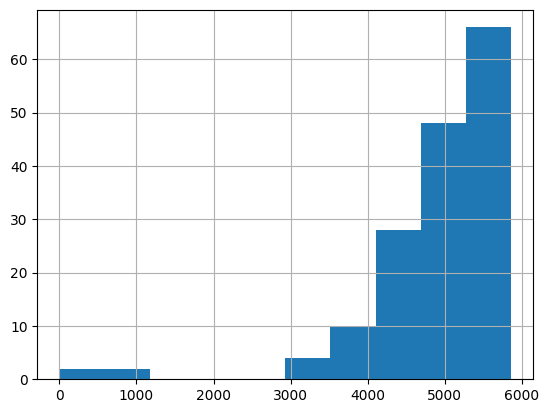

In [14]:
dataframe_160_4_books["context_length"].hist()

<Axes: >

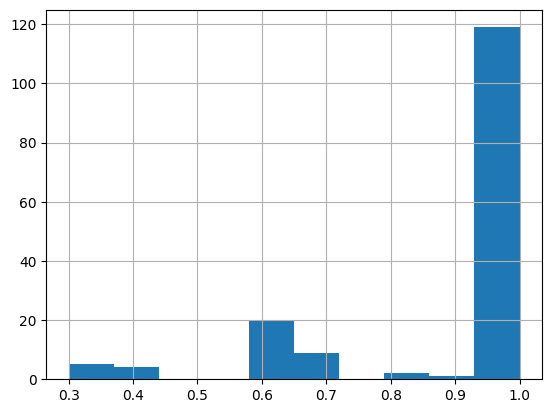

In [13]:
dataframe_160_4_books["synthetic_input_quality"].hist()

In [18]:
high_quality_mask = (dataframe_160_4_books["synthetic_input_quality"] > 0.6) & (dataframe_160_4_books["context_length"] > 2800)
high_quality_df = dataframe_160_4_books[high_quality_mask]

In [ ]:
len(high_quality_df)

129

In [22]:
high_quality_df.to_csv('../data/129 вопросов 4 учебника.csv')

In [20]:
from deepeval.dataset import EvaluationDataset

dataset = EvaluationDataset(goldens=synthesizer.synthetic_goldens)
dataset.push(alias="160 вопросов 4 учебника")

✅ Dataset successfully pushed to Confident AI! View at 
]8;id=784871;https://app.confident-ai.com/project/cm9sl70hj0evpweys5yehloy4/datasets/cmagfxqhm0fypf5670wshcynf\https://app.confident-ai.com/project/cm9sl70hj0evpweys5yehloy4/datasets/cmagfxqhm0fypf5670wshcynf]8;;\

Gtk-Message: 09:54:21.736: Failed to load module "canberra-gtk-module"
Gtk-Message: 09:54:21.736: Failed to load module "pk-gtk-module"
Gtk-Message: 09:54:21.740: Failed to load module "canberra-gtk-module"
Gtk-Message: 09:54:21.740: Failed to load module "pk-gtk-module"


Окно или вкладка откроются в текущем сеансе браузера.


In [24]:
synthesizer.save_as(
    file_type='csv',
    directory="../data",
    file_name = "160 медицинских вопросов 4 учебника confident"
)

Synthetic goldens saved at ../data/160 медицинских вопросов 4 учебника confident.csv!

'../data/160 медицинских вопросов 4 учебника confident.csv'